In [3]:
%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import numpy as np
from typing import Tuple

<figure id="figure-5">
<div style="background-color: white">

![](figures/dwt.svg)
</div>

<figcaption style="text-align: center">

Figure 5: An $L$ level binary discrete wavelet transform.</figcaption></figure>

# 9 The Discrete Wavelet Transform (DWT)

<div class="alert alert-warning alert-block">
    
This notebook is incomplete!</div>

The final method of energy compaction that we shall investigate, is the
discrete wavelet transform. In some ways this attempts to combine the best features of
the Laplacian pyramid and the DCT:

* Like the pyramid, the DWT analyses the image at a range of different
  scales (levels) and employs symmetrical filters;

* Like the DCT, the DWT avoids any expansion in the number of coefficients.

Wavelet theory was evolved by mathematicians during the 1980's. As with the LBT, we shall not attempt to teach this theory here, just illustrate a relatively simple form of it.

Wavelets are short waveforms which are usually the impulse responses of
filters.  Wavelet transforms employ banks of bandpass filters, whose impulse
responses are scaled versions of each other, in
order to get pass-bands in different parts of the frequency spectrum.  If the
impulse response of a filter is scaled in time by a factor $a$, then the
filter frequency response is scaled by the factor $1/a$.  Typically $a = 2$
from one filter to the next, and each bandpass filter is designed to pass a
2:1 range of frequencies (one octave). We can split an image up using wavelets by a process known as a _binary wavelet tree_.

## 9.1 The binary wavelet tree


We start in 1-D with the
simplest possible pair of filters, operating on just two input samples, $x_n$
and $x_{n-1}$.  The two filter outputs, $u_n$ and $v_n$ at time $n$ are
given by:
$$
 u_n = \tfrac{1}{2} (x_n + x_{n-1}) \quad \text{and} \quad
 v_n = \tfrac{1}{2} (x_n - x_{n-1})
$$

The first filter averages adjacent samples, and so rejects the higher
frequency components of $x$, while the second filter differences these
samples, and so rejects the lower frequency components.  These filters are
known as the _analysis_ filter pair, $H_1(z) = \tfrac{1}{2} (1 + z^{-1})$
and $H_2(z) = \tfrac{1}{2} (1 - z^{-1})$.  It is clear that we can recover the
two input samples from the filter outputs using:
$$
 x_n = u_n + v_n \quad \text{and} \quad x_{n-1} = u_n - v_n
$$

Next it is important to note that we need only retain the samples of $u_n$
and $v_n$ at even values of $n$ in order to be able to recover all the
original samples of $x$.  Hence $u$ and $v$ may be decimated 2:1 and still
allow perfect reconstruction of $x$.  If $x$ is a finite length vector (e.g. a
row of image pixels), then $u$ and $v$ are each half as long as $x$, so the
total number of samples is preserved by the transformation.

A wavelet binary tree may be constructed using these filters, by using an
identical pair, $H_1$ and $H_2$, to filter the decimated lowpass signal
$u_{2n}$, to give a pair of outputs, $uu_{2n}$ and $uv_{2n}$, representing
the lower and upper halves of the first low band.  These may again be
decimated 2:1 and still permit perfect reconstruction of $u$.  This process
may be continued as often as desired: each time splitting the lowest band in
two, and decimating the sample rate of the filter outputs by 2:1.  At each
stage the bandwidth of the two lowest filters is halved, and their impulse
responses are doubled in length.  The total number of output samples remains
constant, however many stages are used.

For example, if $f_s$ is the input sample rate, a 3-stage binary tree will
split the input signal bandwidth of 0 to $f_s/2$ into the following four
bands:
$$
0 \rightarrow f_s/16; \ \ f_s/16 \rightarrow f_s/8; \ \ f_s/8 \rightarrow
f_s/4;  \ \ f_s/4 \rightarrow f_s/2.
$$

The very simple filters, given above, do not generate a filter tree with
good characteristics, since the wavelets turn out to be just a pair of
square pulses.  These generate _blocking_ artefacts when used for image
compression (in fact they are equivalent to the 2 point ($N=2$)
DCT). A better set of filters are the LeGall 5 and 3 tap pair,
given by:
$$
 u_n = \tfrac{1}{8} (-x_{n+2} + 2 x_{n+1} + 6 x_n + 2 x_{n-1} - x_{n-2})
  \quad \text{ and }  \quad
 v_{n+1} = \tfrac{1}{4} (-x_{n+2} + 2 x_{n+1} - x_n)
$$

If $u$ and $v$ are decimated by 2 by choosing even $n$ only, the lowband outputs
$u_n$ are centred on the even samples, and the highband outputs $v_{n+1}$ are
centred on the odd samples.  This is very important to allow perfect
reconstruction of $x$ from $u$ and $v$.

The equations for reconstruction may be obtained by solving the above to get:

\begin{align}
 x_n &= \tfrac{1}{2} (-v_{n+1} + 2 u_n - v_{n-1}) \quad \text{and}  \\
 x_{n+1} &= \tfrac{1}{2} (x_{n+2} + 4 v_{n+1} + x_n) =
 \tfrac{1}{4} (-v_{n+3} + 2 u_{n+2} + 6 v_{n+1} + 2 u_n - v_{n-1})
\end{align}

In general, most analysis filters will not yield such simple reconstruction
solutions, and the design of suitable filters is a non-trivial topic that we
shall not cover here.


# 9.2 Applying the DWT to images


As with the DCT, the 2-D DWT may be obtained by applying a 1-D transform to
first the rows and then the columns of an image.

Start by loading the Lighthouse image and defining the two LeGall
filters given above:

In [4]:
X, _ = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
h1 = np.array([-1, 2, 6, 2, -1])/8
h2 = np.array([-1, 2, -1])/4

We can use the function `rowdec` from the pyramid work, to
produce a decimated and lowpass filtered version of the rows of
`X` (remembering to subtract 128 as before) using:

In [5]:
from cued_sf2_lab.laplacian_pyramid import rowdec
U = rowdec(X, h1)

To get the high-pass image `V`, it is important to align the decimated
samples with the odd columns of `X` (assuming the first column is $n = 0$)
whereas `U` is aligned with the even columns.  To do this we use a
slightly modified version of `rowdec`, called `rowdec2`.

In [6]:
from cued_sf2_lab.laplacian_pyramid import rowdec2
V = rowdec2(X, h2)

<div class="alert alert-block alert-danger">

Display `U` and `V` to see the outputs of the first filter pair
and comment on their relative energies (or standard deviations). Note that `U` and `V` are half the width of `X`, but that `U` is otherwise similar to `X`.</div>

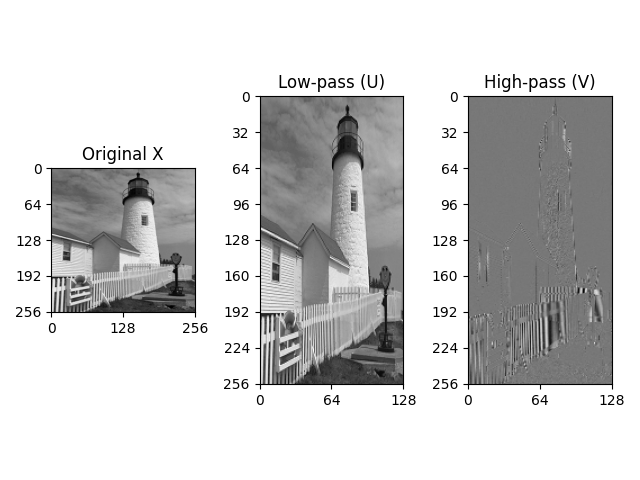

82309592.40625
3501848.25


In [7]:
# your code here

# X is the original image (after subtracting 128)
# U = rowdec(X, h1)  → low-pass filtered
# V = rowdec2(X, h2) → high-pass filtered

# Display X, U, and V side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plot_image(X, ax=ax1)
ax1.set_title("Original X")

plot_image(U, ax=ax2)
ax2.set_title("Low-pass (U)")

plot_image(V, ax=ax3)
ax3.set_title("High-pass (V)")

plt.tight_layout()
plt.show()

print(np.sum(U**2))
print(np.sum(V**2))


Now filter the columns of `U` and `V` using `rowdec
/ rowdec2` with the transpose operator:

In [8]:
UU = rowdec(U.T, h1).T
UV = rowdec2(U.T, h2).T
VU = rowdec(V.T, h1).T
VV = rowdec2(V.T, h2).T

<div class="alert alert-block alert-danger">
    
Display `np.block([[UU, VU], [UV, VV]])`, and comment
on what sort of edges or features are selected by each filter. You may need to multiply the high-pass images by a factor $k > 1$ to display them clearly. Why is this?</div>

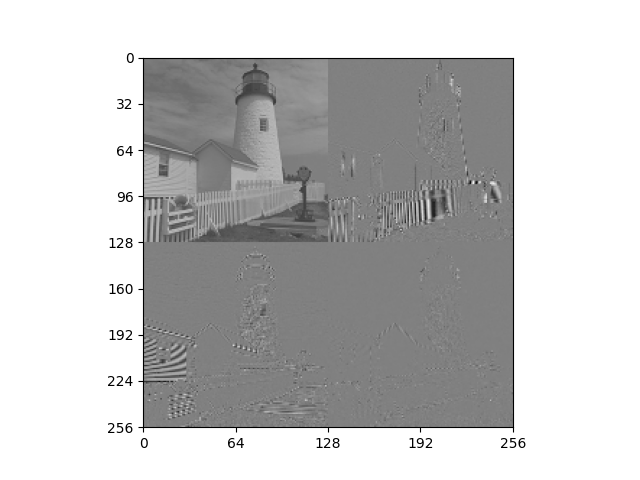

In [9]:
# your code here
k=3
plt.figure()
plot_image(np.block([[UU, k * VU], [k * UV, k * VV]]))
plt.show()


We must now check that it is possible to recover the image from
these sub-images, using reconstruction filters, `g1` and `g2`, and the functions, `rowint` and `rowint` (which
is modified in a similar way to `rowdec2` to allow correct
alignment of the high-pass samples). To reconstruct `Ur` and
`Vr` from `UU`, `UV`, `VU` and `VV` use:

In [10]:
from cued_sf2_lab.laplacian_pyramid import rowint, rowint2

g1 = np.array([1, 2, 1])/2
g2 = np.array([-1, -2, 6, -2, -1])/4
Ur = rowint(UU.T, g1).T + rowint2(UV.T, g2).T
Vr = rowint(VU.T, g1).T + rowint2(VV.T, g2).T

Note the gain of 2 in the reconstruction filters, `g1` and
`g2` (to compensate for losing half the samples in the
decimation / interpolation processes).   These filters are also
not quite the same as those that might be inferred from the
equations for $x_n$ and $x_{n+1}$ on the previous page.  This is
because `g1` defines how {\it only} the $u$ samples contribute
both to the even and odd samples of $x$, while `g2` defines
how the $v$ samples contribute.

Check that `Ur` and `Vr` are the same as `U` and
`V`, and then reconstruct `Xr` from these:

In [11]:
# your code here to check Ur and Vr


In [12]:
# demonstrator answer here
np.testing.assert_equal(Ur, U)
np.testing.assert_equal(Vr, V)

In [13]:
Xr = rowint(Ur,g1) + rowint2(Vr,g2)

Check that `Xr` is the same as `X`.

In [14]:
# your code here
np.testing.assert_equal(Xr, X)

The above operations are a bit tedious to repeat if we want to
apply the DWT recursively to obtain several levels of filtering,
so we have written a pair of functions, `dwt` and `idwt`, to perform the 2-D analysis and reconstruction
operations. Examine these to see that they perform the same
operations as above, except that the transformed sub-images are
stored as parts of a single matrix, the same size as `X`,
rather than as separate matrices.

In [15]:
from cued_sf2_lab.dwt import dwt
IPython.display.Code(inspect.getsource(dwt), language="python")

def dwt(X: np.ndarray, h1: np.ndarray = h1, h2: np.ndarray = h2) -> np.ndarray:
    """
    Return a 1-level 2-D discrete wavelet transform of X.

    Default h1 and h2 are the LeGall filter pair.

    Parameters:
        X: Image matrix (Usually 256x256)
        h1, h2: Filter coefficients
    Returns:
        Y: 1-level 2D DWT of X
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    Y = np.concatenate([rowdec(X, h1), rowdec2(X, h2)], axis=1)
    Y = np.concatenate([rowdec(Y.T, h1).T, rowdec2(Y.T, h2).T], axis=0)
    return Y

In [16]:
from cued_sf2_lab.dwt import idwt
IPython.display.Code(inspect.getsource(idwt), language="python")

def idwt(X: np.ndarray, g1: np.ndarray = g1, g2: np.ndarray = g2)-> np.ndarray:
    """
    Return a 1-level 2-D inverse discrete wavelet transform on X.

    If filters G1 and G2 are given, then they are used, otherwise the LeGall
    filter pair are used.
    """
    m, n = X.shape
    if m % 2 or n % 2:
        raise ValueError("Image dimensions must be even")
    m2 = m//2
    n2 = n//2
    Y = rowint(X[:m2, :].T, g1).T + rowint2(X[m2:, :].T,g2).T;
    Y = rowint(Y[:, :n2], g1) + rowint2(Y[:, n2:], g2)
    return Y

You can check their operation as below::

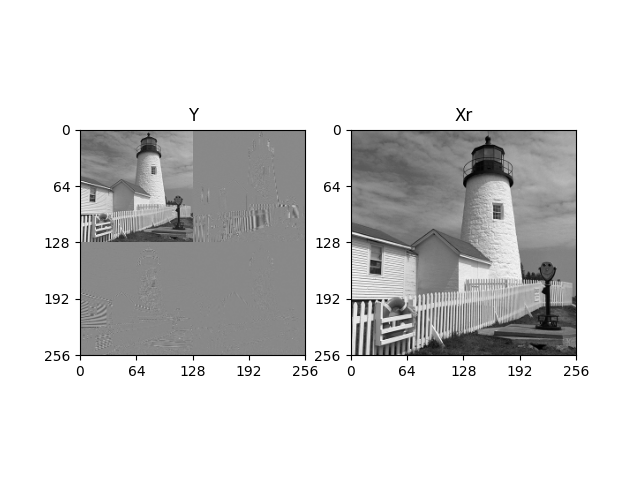

In [17]:
Y = dwt(X)
Xr = idwt(Y)

fig, axs = plt.subplots(1, 2)
plot_image(Y, ax=axs[0])
axs[0].set(title="Y")
plot_image(Xr, ax=axs[1])
axs[1].set(title="Xr");

`Y` should be the same as the composite `[UU VU; UV VV]` image that
you displayed earlier, and `Xr` should be the same as `X`.

Now implement a multilevel DWT by first applying `dwt` to
`X` using:

```python
m=256
Y=dwt(X)
plot_image(Y, ax=some_axis)
```

and then iteratively apply `dwt` to the top left sub-image
of `Y` by repeating:
```python
m = m//2
Y[:m,:m] = dwt(Y[:m,:m])
plot_image(Y, ax=some_axis)
```

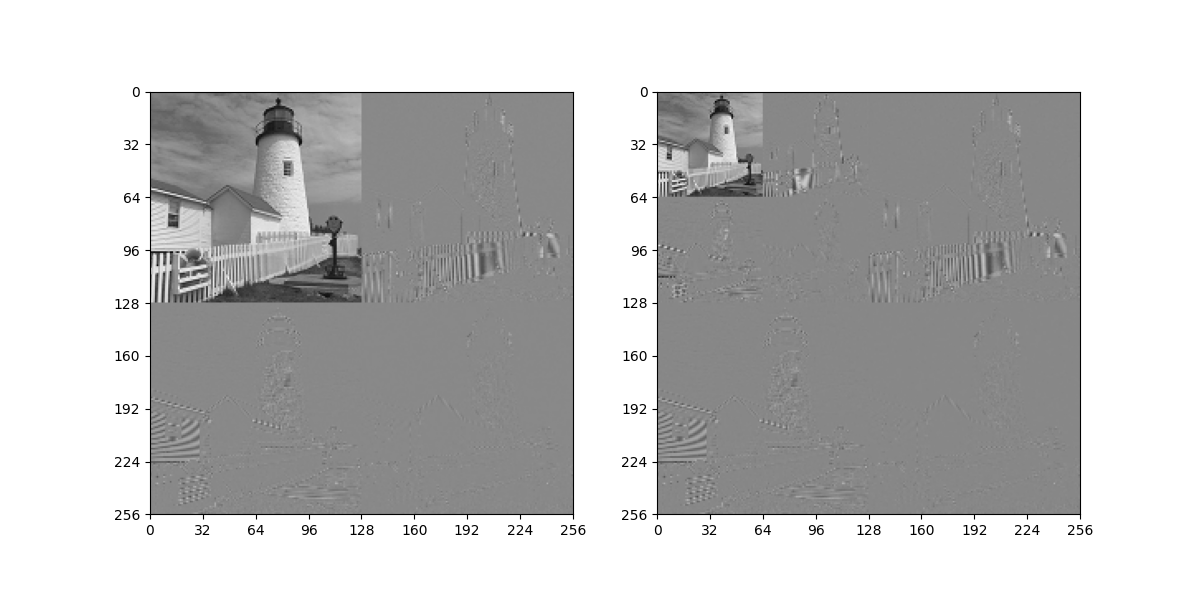

In [18]:
# your code here
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
m = 256
Y = dwt(X)
plot_image(Y, ax = ax1)
m = m // 2
Y[:m, :m] = dwt (Y[:m, :m])
plot_image (Y, ax = ax2)
plt.show()

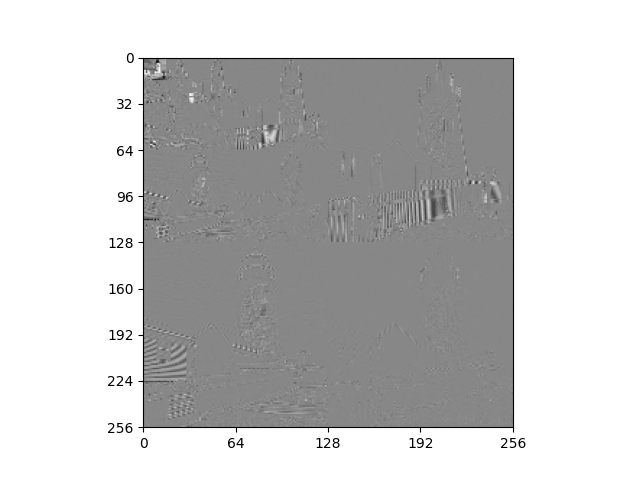

In [19]:
fig, ax3 = plt.subplots()

m = m // 2
Y[:m, :m] = dwt(Y[:m, :m])
m = m // 2
Y[:m, :m] = dwt(Y[:m, :m])
plot_image(Y, ax=ax3)


We now have the image split using a binary wavelet tree (stricly a
quaternary tree in 2-D).  Write
similar iterative code to that given above, which can reconstruct
the image from the final set of `Y` sub-images after a 4-level
wavelet transform. Check that your reconstructed image is the
same as `X`.

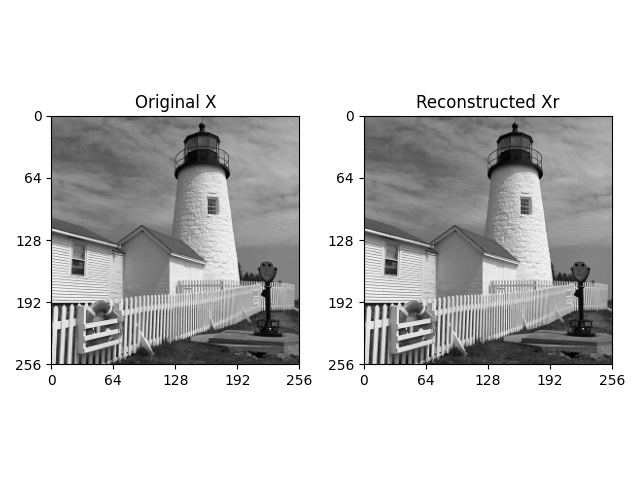

RMS error: 0.00000


In [20]:
# your code here
# Start from size of final lowpass region (top-left)

        
m = 16   # 256 → 128 → 64 → 32 → 16

# Reconstruct iteratively up to full size
for i in range(4):
    Y[:m*2, :m*2] = idwt(Y[:m*2, :m*2])
    m *= 2

# Final reconstructed image
Xr = Y

# Check visually or with RMS error
fig, (ax1, ax2) = plt.subplots(1, 2)
plot_image(X, ax=ax1); ax1.set_title("Original X")
plot_image(Xr, ax=ax2); ax2.set_title("Reconstructed Xr")
plt.tight_layout(); plt.show()

# Optional: check reconstruction accuracy
print(f"RMS error: {np.std(X - Xr):.5f}")


## 9.3 Quantisation and coding efficiency

First rewrite the sequences of operations required to perform
$n$ levels of DWT and inverse DWT as two separate M-files, `nlevdwt` and `nlevidwt`. `nlevdwt` should transform
`X` into `Y`, and `nlevidwt` should inverse
transform a quantised set of sub-images `Yq` into the
reconstructed image `Z`.  Check your functions by ensuring
that `Z` is the same as `X` if `Yq = Y`.

In [21]:
def nlevdwt(X, n):
    Y = X.copy()
    m, _ = Y.shape
    for i in range(n):
        Y[:m, :m] = dwt(Y[:m, :m])
        m = m // 2
    return Y


def nlevidwt(Yq, n):
    Z = Yq.copy()
    m, _ = Z.shape
    m = m // (2 ** (n - 1))
    for _ in range(n):
        Z[:m, :m] = idwt(Z[:m, :m])
        m = m * 2
    return Z

In [22]:
# your code here to test `nlevdwt` and `nlevidwt`
Y = nlevdwt(X, n=4)
Z = nlevidwt(Y, n=4)
print("RMS error:", np.std(X - Z))  # should be ~0 if perfect reconstruction

RMS error: 0.0


Now design a function, `quantdwt`, which will quantise the
sub-images of `Y` to give `Yq` and calculate their
entropy.  The sub-images at each level `i` of the DWT should
be quantised according to a $3 \times (n+1)$ matrix `dwtstep[k,i]` of
step-sizes, where $\mathtt{k}=\left\{0,1,2\right\}$ corresponds to each of the three high-pass images at level `i` (top right, bottom left, and bottom right, respectively), and the final low-pass image is quantised with `dwtstep[0,n]`. This matrix will be populated either with the same number in all elements (for equal-step-size quantisation) or a range of different numbers (for equal-MSE quantisation). The entropies for each sub-image should be stored in a similar $3 \times (n+1)$ matrix `dwtent[k,i]`.

In [23]:
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters:
        Y: the output of `dwt(X, n)`
        dwtstep: an array of shape `(3, n+1)`
    Returns:
        Yq: the quantized version of `Y`
        dwtenc: an array of shape `(3, n+1)` containing the entropies
    """
    m = Y.shape[0]
    n_levels = dwtstep.shape[1] - 1
    Yq = Y.copy()
    dwtent = np.zeros((3, n_levels + 1))
    bits = 0

    for i in range(n_levels):
        m = m // 2
        # top right (horizontal)
        Q = quantise(Yq[:m, m:2*m], dwtstep[0, i])
        dwtent[0, i] = bpp(Q)  # entropy
        Yq[:m, m:2*m] = Q
        bits_top_right = dwtent[0, i] *m*m
        bits += bits_top_right

        # bottom left (vertical)
        Q = quantise(Yq[m:2*m, :m], dwtstep[1, i])
        dwtent[1, i] = bpp(Q)
        Yq[m:2*m, :m] = Q
        bits_bottom_left = dwtent[1, i] *m*m
        bits += bits_bottom_left

        # bottom right (diagonal)
        Q = quantise(Yq[m:2*m, m:2*m], dwtstep[2, i])
        dwtent[2, i] = bpp(Q)
        Yq[m:2*m, m:2*m] = Q
        bits_bottom_right = dwtent[2, i] *m*m
        bits += bits_bottom_right

        

    # Final low-pass (top-left)
    Q = quantise(Yq[:m, :m], dwtstep[0, n_levels])
    dwtent[0, n_levels] = bpp(Q)
    Yq[:m, :m] = Q
    bits_top_left = dwtent[0, n_levels]* m*m
    bits += bits_top_left
    return Yq, dwtent, bits


Using these functions, for a given number of levels $n$ (typically
between 3 and 5), you should generate `Y`, quantise it to
give `Yq` and reconstruct `Z` from `Yq`.

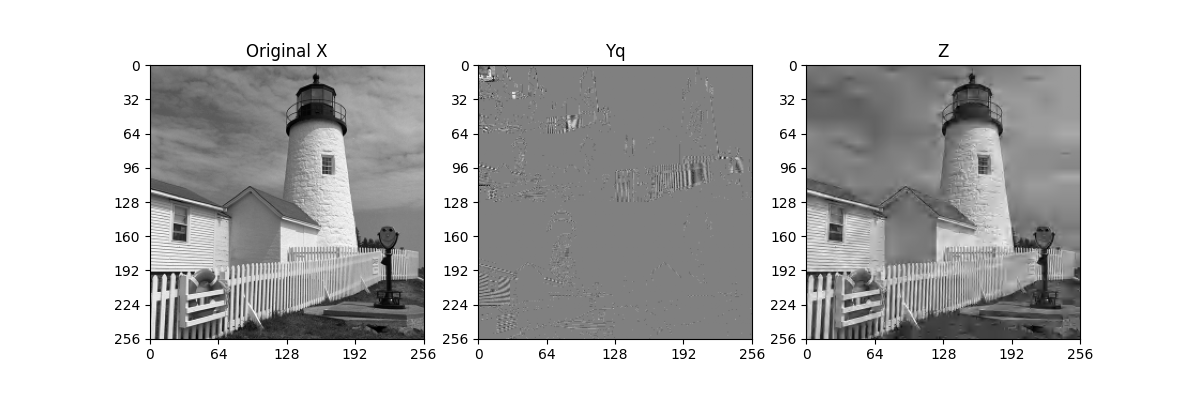

[[0.91278689 1.06763722 1.14458482 1.35167841 3.37736165]
 [0.80317283 1.06184434 1.37365956 1.63717336 0.        ]
 [0.14154013 0.31992385 0.62362184 0.70253722 0.        ]]


In [24]:
# your code here
# Set number of levels (e.g. 4)
n = 4

# Step sizes: use uniform or varied values; here we use 3×(n+1) array of equal values
step = 17
dwtstep = step * np.ones((3, n + 1))

# 1. Perform multi-level DWT
Y = nlevdwt(X, n)

# 2. Quantise the sub-images
Yq, dwent, bits = quantdwt(Y, dwtstep)

# 3. Reconstruct the image
Z = nlevidwt(Yq, n)

# 4. Compare with original image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,4))
plot_image(X, ax=ax1); ax1.set_title("Original X")
plot_image(Yq, ax=ax2); ax2.set_title("Yq")
plot_image(Z, ax=ax3); ax3.set_title("Z")

plt.show()
print(dwent)


In [25]:
print(np.std(X - Z))

10.13530760983734


All of our experiments thus far have been performed on only one image. At this stage it is worth starting to experiment with the additional `Bridge` image, as well as Lighthouse. Bridge contains a lot more fine detail and may not lead to the same conclusions regarding performance.

In [26]:
Xb, _ = load_mat_img(img='bridge.mat', img_info='X', cmap_info={'map'})
Xb = Xb - 128.0

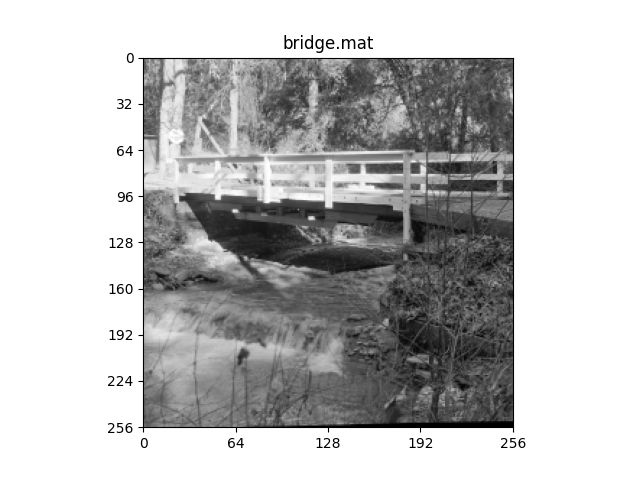

In [27]:
fig, ax = plt.subplots()
plot_image(Xb, ax=ax)
ax.set(title="bridge.mat");

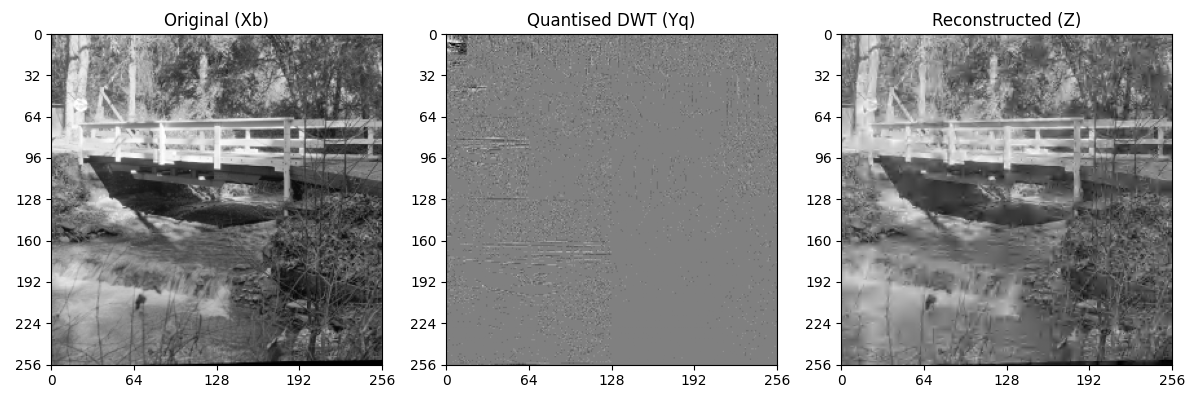

In [28]:
# Load and preprocess the image
Xb, _ = load_mat_img(img='bridge.mat', img_info='X', cmap_info={'map'})
Xb = Xb - 128.0

# Set number of DWT levels
n = 4

# Define step sizes (equal for simplicity)
step = 17
dwtstep = step * np.ones((3, n + 1))

# 1. Perform multi-level DWT
Y = nlevdwt(Xb, n)

# 2. Quantise the sub-images
Yq, dwtent,bits = quantdwt(Y, dwtstep)

# 3. Reconstruct the image
Z = nlevidwt(Yq, n)

# 4. Plot original, quantised DWT, and reconstructed image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
plot_image(Xb, ax=ax1); ax1.set_title("Original (Xb)")
plot_image(Yq, ax=ax2); ax2.set_title("Quantised DWT (Yq)")
plot_image(Z,  ax=ax3); ax3.set_title("Reconstructed (Z)")
plt.tight_layout()
plt.show()
print()



<div class="alert alert-block alert-danger">

Investigate the performance of
both an equal-step-size and an equal-MSE scheme (follow a similar procedure as you used for the Laplacian Pyramid to find the appropriate step-size ratios). Hence determine how many levels of DWT are reasonably optimal for the Lighthouse and Bridge images. Also evaluate the subjective quality of your reconstructed images, and comment on how this depends on $n$ and on the way that step-sizes are assigned
to the different levels. Once again, for each image choose quantisation steps such that you match the rms error to that for direct quantisation with a step-size of 17.</div>

In [29]:
# your code here\
from cued_sf2_lab.laplacian_pyramid import bpp, quantise
Xbq = quantise(Xb, step = 17)
rms_Xb = np.std(Xb-Xbq)
print(rms_Xb)

Xq = quantise(X, step = 17)
rms_X = np.std(X-Xq)
print(rms_X)





4.922258215108269
4.861168497356846


In [30]:
# optimise the step

def rms_DWT(X, 
            n: int, 
            step: float):

    dwtstep = step * np.ones((3, n + 1))

    # 1. Perform multi-level DWT
    Y = nlevdwt(X, n)

    # 2. Quantise the sub-images
    Yq, dwtent,bits = quantdwt(Y, dwtstep)

    # 3. Reconstruct the image
    Z = nlevidwt(Yq, n)

    rms1 = np.std(Z-X)

    return rms1, dwtent, bits


target_err = rms_X
def find_step_DWT(target_err: float,
                  n: int,
                  lo: float = 1.0,
                  hi: float = 50.0,
                  tol: float = 1e-3,
                  max_iter: int = 5000):
    """Binary-search Δ so that rms_DWT(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e,dwtent, bits  = rms_DWT(X, n, mid)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e, bits

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e, bits   #mid is the matched step size, e is the error

bits_ref = bpp(Xq) * Xq.size
# optimise step size
for n in [3,4,5]: 
    opt_step, opt_error, total_bits = find_step_DWT(rms_X,n)
    CPR = bits_ref/ total_bits
    print(f"\n n={n}: matched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}, number of bits = {total_bits}, CPR = {CPR}")
    


 n=3: matched step ≈ 7.645  →  RMS = 4.862, number of bits = 84853.28081187766, CPR = 2.6883938291606473

 n=4: matched step ≈ 6.566  →  RMS = 4.861, number of bits = 91754.24538113143, CPR = 2.486195985494949

 n=5: matched step ≈ 5.582  →  RMS = 4.860, number of bits = 101252.7742205534, CPR = 2.2529657905647915


In [31]:
# Using Xb
target_err = rms_Xb
print(rms_Xb)
def find_step_DWT(target_err: float,
                  n: int,
                  lo: float = 1.0,
                  hi: float = 50.0,
                  tol: float = 1e-3,
                  max_iter: int = 5000):
    """Binary-search Δ so that rms_DWT(step) ≈ target_err."""    
    for _ in range(max_iter):          # failsafe upper bound
        mid = 0.5 * (lo + hi)
        e,dwtent, bits  = rms_DWT(Xb, n, mid)

        # stop if we're close enough
        if abs(e - target_err) <= tol:
            return mid, e, bits

        # otherwise shrink the half-interval that gives too much error
        if e > target_err:
            hi = mid          # error too big, we need a smaller step
        if e < target_err:
            lo = mid          # error too small ⇒ we need a larger step

    # If we drop out because of max_iter, return the best we have
    return mid, e, bits   #mid is the matched step size, e is the error

bits_ref = bpp(Xbq) * Xbq.size
# optimise step size
for n in [3,4,5]: 
    opt_step, opt_error, total_bits = find_step_DWT(rms_Xb,n)
    CPR = bits_ref/ total_bits
    print(f"\n n={n}: matched step ≈ {opt_step:.3f}  →  RMS = {opt_error:.3f}, number of bits = {total_bits}, CPR = {CPR}")
    

4.922258215108269

 n=3: matched step ≈ 6.132  →  RMS = 4.922, number of bits = 134616.31327721453, CPR = 1.760935621828807

 n=4: matched step ≈ 5.513  →  RMS = 4.923, number of bits = 142114.16341246985, CPR = 1.6680298123495352

 n=5: matched step ≈ 5.034  →  RMS = 4.923, number of bits = 149742.66859866734, CPR = 1.5830535380963748


In [32]:
def compute_equal_mse_dwtsteps(Y: np.ndarray, n: int) -> np.ndarray:
    """
    Compute DWT step sizes for equal-MSE allocation across subbands.

    Parameters
    ----------
    Y : ndarray
        The DWT-transformed image.
    n : int
        Number of DWT levels.

    Returns
    -------
    dwtstep : ndarray
        Step sizes for each subband, shape (3, n+1), scaled to unit RMS.
    """
    m = Y.shape[0]
    dwtstep = np.zeros((3, n + 1))
    
    for i in range(n):
        m = m // 2

        std_h = np.std(Y[:m, m:2*m])   # horizontal
        std_v = np.std(Y[m:2*m, :m])   # vertical
        std_d = np.std(Y[m:2*m, m:2*m])# diagonal

        dwtstep[0, i] = 1 / std_h if std_h > 0 else 0
        dwtstep[1, i] = 1 / std_v if std_v > 0 else 0
        dwtstep[2, i] = 1 / std_d if std_d > 0 else 0

    std_lp = np.std(Y[:m, :m])
    dwtstep[0, n] = 1 / std_lp if std_lp > 0 else 0

    norm = np.linalg.norm(dwtstep)
    if norm > 0:
        dwtstep /= norm

    return dwtstep


In [33]:

def compute_equal_mse_dwtsteps(Y: np.ndarray, n: int) -> np.ndarray:
    """
    Compute DWT step sizes for equal-MSE allocation across subbands.

    Parameters
    ----------
    Y : ndarray
        The DWT-transformed image.
    n : int
        Number of DWT levels.

    Returns
    -------
    dwtstep : ndarray
        Step sizes for each subband, shape (3, n+1), scaled to unit RMS.
    """
    m = Y.shape[0]
    dwtstep = np.zeros((3, n + 1))
    
    for i in range(n):
        m = m // 2

        std_h = np.std(Y[:m, m:2*m])   # horizontal
        std_v = np.std(Y[m:2*m, :m])   # vertical
        std_d = np.std(Y[m:2*m, m:2*m])# diagonal

        dwtstep[0, i] = 1 / std_h if std_h > 0 else 0
        dwtstep[1, i] = 1 / std_v if std_v > 0 else 0
        dwtstep[2, i] = 1 / std_d if std_d > 0 else 0

    std_lp = np.std(Y[:m, :m])
    dwtstep[0, n] = 1 / std_lp if std_lp > 0 else 0

    norm = np.linalg.norm(dwtstep)
    if norm > 0:
        dwtstep /= norm

    return dwtstep


for n in [3,4,5]:
    Y = nlevdwt(X, n)
    dwtstep = compute_equal_mse_dwtsteps(Y, n)
    print(f"\n n={n}, opt_step = {dwtstep}")




 n=3, opt_step = [[0.17003087 0.1355179  0.11587647 0.03790948]
 [0.21080524 0.16063105 0.12645111 0.        ]
 [0.7187594  0.48216732 0.32020063 0.        ]]

 n=4, opt_step = [[0.16185398 0.12900076 0.1103039  0.14434404 0.03761489]
 [0.20066748 0.15290619 0.12036999 0.10544447 0.        ]
 [0.68419379 0.45897957 0.30480198 0.24860052 0.        ]]

 n=5, opt_step = [[0.15691978 0.1250681  0.10694123 0.13994364 0.10373857 0.0379918 ]
 [0.19455003 0.14824477 0.11670045 0.10222994 0.09111815 0.        ]
 [0.6633358  0.44498735 0.29550994 0.24102181 0.20214838 0.        ]]


In [36]:


# Load image
X, _ = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0
Xq = quantise(X, step=17)
rms_X = np.std(X - Xq)
bits_ref = bpp(Xq) * Xq.size

def quantdwt_with_bits(Y, dwtstep):
    m = Y.shape[0]
    n_levels = dwtstep.shape[1] - 1
    Yq = Y.copy()
    bits = 0

    for i in range(n_levels):
        m = m // 2
        for b, (r, c) in enumerate([(slice(0, m), slice(m, 2*m)),  # H
                                    (slice(m, 2*m), slice(0, m)),  # V
                                    (slice(m, 2*m), slice(m, 2*m))]):  # D
            Q = quantise(Yq[r, c], dwtstep[b, i])
            Yq[r, c] = Q
            bits += bpp(Q) * (m * m)

    Q = quantise(Yq[:m, :m], dwtstep[0, n_levels])
    Yq[:m, :m] = Q
    bits += bpp(Q) * (m * m)

    return Yq, bits

def find_equal_mse_steps(X, n, target_rms):
    Y = nlevdwt(X, n)
    dwtstep = np.ones((3, n + 1))

    def reconstruct_rms(dwtstep):
        Yq, _ = quantdwt_with_bits(Y, dwtstep)
        Z = nlevidwt(Yq, n)
        return np.std(Z - X)

    for b in range(3):
        for i in range(n + 1):
            lo, hi = 0.01, 100
            for _ in range(20):
                mid = (lo + hi) / 2
                dwtstep[b, i] = mid
                e = reconstruct_rms(dwtstep)
                if abs(e - target_rms) < 0.001:
                    break
                if e > target_rms:
                    hi = mid
                else:
                    lo = mid

    Yq_final, bits = quantdwt_with_bits(Y, dwtstep)
    Z_final = nlevidwt(Yq_final, n)
    rms_error = np.std(Z_final - X)
    cpr = bits_ref / bits

    return dwtstep, rms_error, cpr

# Run for n = 3, 4, 5
for n in [3, 4, 5]:
    steps, rms, cpr = find_equal_mse_steps(X, n, rms_X)
    print(f"\n--- n = {n} ---")
    print(f"Step sizes:\n{steps}")
    print(f"RMS Error: {rms:.4f}")
    print(f"Compression Ratio: {cpr:.4f}")



--- n = 3 ---
Step sizes:
[[32.00142944  0.98646484  0.98646484  0.98646484]
 [ 1.08411133  0.79117187  1.18175781 50.005     ]
 [ 0.98646484  0.98646484  0.98646484 50.005     ]]
RMS Error: 4.8615
Compression Ratio: 1.3062

--- n = 4 ---
Step sizes:
[[31.90378296  0.98646484  0.98646484  1.18175781  0.79117187]
 [ 0.98646484  0.98646484  1.18175781  0.98646484 50.005     ]
 [ 0.98646484  0.98646484  0.98646484  0.98646484 50.005     ]]
RMS Error: 4.8604
Compression Ratio: 1.3626

--- n = 5 ---
Step sizes:
[[31.70848999  0.98646484  0.98646484  1.18175781  0.98646484  0.79117187]
 [ 0.98646484  0.98646484  1.08411133  1.18175781  0.98646484 50.005     ]
 [ 0.98646484  0.98646484  0.98646484  0.98646484  0.98646484 50.005     ]]
RMS Error: 4.8606
Compression Ratio: 1.3653


In [ ]:

# Load image
X, _ = load_mat_img('lighthouse.mat', 'X')
X = X - 128
Xq = quantise(X, step=17)
rms_X = np.std(X - Xq)
bits_ref = bpp(Xq) * X.size

# Impulse energy measurement for DWT

def impulse_energy_dwt(n: int, shape: tuple, amplitude: float = 100) -> np.ndarray:
    energies = np.zeros((3, n + 1))
    for lev in range(n):
        m = shape[0] >> lev
        m = m // 2
        for b, (r, c) in enumerate([(slice(0, m), slice(m, 2*m)),
                                    (slice(m, 2*m), slice(0, m)),
                                    (slice(m, 2*m), slice(m, 2*m))]):
            Y = np.zeros(shape)
            Y[r, c] = amplitude
            Z = nlevidwt(Y, n)
            energies[b, lev] = np.sum(Z**2)

    # Low-pass band
    m = shape[0] >> n
    Y = np.zeros(shape)
    Y[:m, :m] = amplitude
    Z = nlevidwt(Y, n)
    energies[0, n] = np.sum(Z**2)

    return energies

# Step ratios from impulse energies
def compute_equal_mse_dwtsteps(X: np.ndarray, n: int) -> np.ndarray:
    Y = nlevdwt(X, n)
    E = impulse_energy_dwt(n, Y.shape)
    ratios = 1 / np.sqrt(E)
    ratios /= ratios[0, n]  # Normalize so low-pass = 1
    return ratios

# Quantise DWT with custom step sizes and get bits
def quantdwt_with_bits(Y, dwtstep):
    m = Y.shape[0]
    n_levels = dwtstep.shape[1] - 1
    Yq = Y.copy()
    bits = 0
    for i in range(n_levels):
        m = m // 2
        for b, (r, c) in enumerate([(slice(0, m), slice(m, 2*m)),
                                    (slice(m, 2*m), slice(0, m)),
                                    (slice(m, 2*m), slice(m, 2*m))]):
            Q = quantise(Yq[r, c], dwtstep[b, i])
            Yq[r, c] = Q
            bits += bpp(Q) * (m * m)

    Q = quantise(Yq[:m, :m], dwtstep[0, n_levels])
    Yq[:m, :m] = Q
    bits += bpp(Q) * (m * m)

    return Yq, bits

# Run equal MSE compression for different n
for n in [3, 4, 5]:
    step_ratios = compute_equal_mse_dwtsteps(X, n)
    step = 17
    dwtstep = step * step_ratios
    Y = nlevdwt(X, n)
    Yq, total_bits = quantdwt_with_bits(Y, dwtstep)
    Z = nlevidwt(Yq, n)
    rms = np.std(Z - X)
    cpr = bits_ref / total_bits
    print(f"\n--- n = {n} ---")
    print(f"Step sizes:\n{np.round(dwtstep, 2)}")
    print(f"RMS Error: {rms:.4f}")
    print(f"Compression Ratio: {cpr:.4f}")


/tmp/ipykernel_57627/1928934784.py:36: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / np.sqrt(E)



--- n = 3 ---
Step sizes:
[[17.   23.95 27.41 17.  ]
 [17.   23.95 27.41   inf]
 [17.   33.74 44.18   inf]]
RMS Error: 73.2074
Compression Ratio: 1.7685

--- n = 4 ---
Step sizes:
[[17.   23.95 27.41 28.17 17.  ]
 [17.   23.95 27.41 28.17   inf]
 [17.   33.74 44.18 46.67   inf]]
RMS Error: 73.3507
Compression Ratio: 1.7870

--- n = 5 ---
Step sizes:
[[17.   23.95 27.41 28.17 27.67 17.  ]
 [17.   23.95 27.41 28.17 27.67   inf]
 [17.   33.74 44.18 46.67 45.04   inf]]
RMS Error: 73.5593
Compression Ratio: 1.7913


## 9.4 Second Interim Report

This report should include the new results from the DCT, LBT and DWT energy
compaction methods in a format that will allow them to be compared with each other and contrasted to the
Laplacian pyramid work in your first report.  Again try to answer questions
raised in the text, and also include discussion of any topics that have led to
unexpected results or have proved particularly interesting.